<img src="https://www.nhm.ac.uk/content/dam/nhmwww/discover/manatees/manatee-close-up-full-width.jpg.thumb.1160.1160.jpg" alt="drawing" width="600"/>

# Chapter 8: Conditional Manatees - Samples

## 8.1 Building an Interaction

Rugged terrain example.

### 8.1.1 Making a rugged model

In [4]:
# Code 8.1

from rethinking import DATA_PATH
import pandas as pd
import numpy as np

d = pd.read_csv(DATA_PATH.joinpath('rugged.csv'), sep=';')

# make log version of outcome
d['log_gdp'] = np.log(d['rgdppc_2000'])

# extract countries with GDP data
dd = d.dropna(subset=['rgdppc_2000'])

# rescale variables
log_gdp_std = (dd['log_gdp'] / dd['log_gdp'].mean()).values
rugged_std = (dd['rugged'] / dd['rugged'].max()).values

Model to use (geocentric skeleton)

$$
\begin{aligned}
\log(y_i) &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta(r_i - \bar{r}) \\
\alpha &\sim \text{Normal}(1,1) \\
\beta &\sim \text{Normal}(0,1) \\
\sigma &\sim \text{Exponential}(1)
\end{aligned}
$$

In [10]:
# Code 8.2

import pymc as pm
from rethinking import quap

with pm.Model() as model:
    a = pm.Normal('a', 1, 1)
    b = pm.Normal('b', 0, 1)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + b * (rugged_std - 0.215))
    gdp_result = pm.Normal('gdp_result', mu, sigma, observed=log_gdp_std)
    post, vars_ = quap(model)

Before checking the results, let's look at the prior predictions.

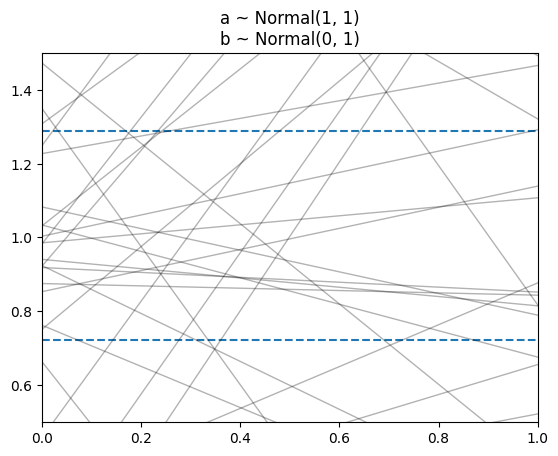

In [30]:
from matplotlib import pyplot as plt

# Code 8.3

with model:
    model81_prior = pm.sample_prior_predictive()

    
plt.ylim(0.5, 1.5)
plt.xlim(0, 1)
plt.axhline(log_gdp_std.min(), ls="--")
plt.axhline(log_gdp_std.max(), ls="--")

# draw 50 lines from the prior
rugged_seq = np.linspace(-0.1, 1.1, 50)
prior = model81_prior.prior.sel(draw=slice(None, None, int(len(model81_prior.prior.draw) / 50)))
mu = prior['a'].T.to_numpy() + prior['b'].T.to_numpy() * (rugged_seq - 0.215)
for m in mu:
    plt.plot(
        rugged_seq,
        m,
        color='k',
        lw=1,
        alpha=0.3,
    )
plt.title('a ~ Normal(1, 1)\nb ~ Normal(0, 1)');

We need to make the priors more plausible.

In [44]:
# Code 8.4

np.sum(abs(prior['b'].to_numpy()) > 0.6) / prior['b'].shape[1]

0.56

Under the $B \sim \text{Normal}(0, 1)$ prior, more than half of all slopes will have an absolute value greater than 0.6.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


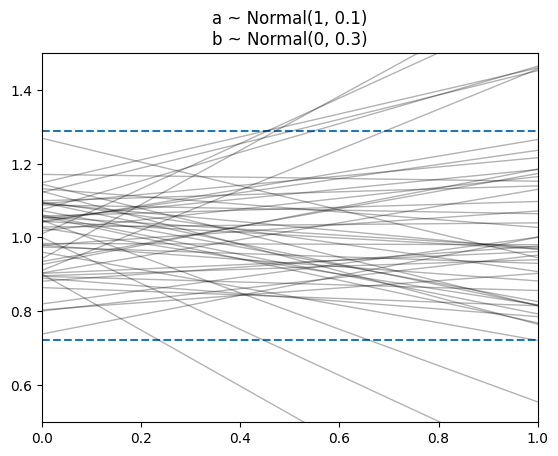

In [93]:
# Code 8.5

import pymc as pm
from rethinking import quap

with pm.Model() as model:
    a = pm.Normal('a', 1, 0.1)
    b = pm.Normal('b', 0, 0.3)
    sigma = pm.Exponential('sigma', 1)
    mu = a + b * (rugged_std - 0.215)
    gdp_result = pm.Normal('gdp_result', mu, sigma, observed=log_gdp_std)
    post81, vars_ = quap(model)
    trace81 = pm.sample()
    
    
with model:
    model81_prior = pm.sample_prior_predictive()

    
plt.ylim(0.5, 1.5)
plt.xlim(0, 1)
plt.axhline(log_gdp_std.min(), ls="--")
plt.axhline(log_gdp_std.max(), ls="--")

# draw 50 lines from the prior
rugged_seq = np.linspace(-0.1, 1.1, 50)
prior = model81_prior.prior.sel(draw=slice(None, None, int(len(model81_prior.prior.draw) / 50)))
mu = prior['a'].T.to_numpy() + prior['b'].T.to_numpy() * (rugged_seq - 0.215)
for m in mu:
    plt.plot(
        rugged_seq,
        m,
        color='k',
        lw=1,
        alpha=0.3,
    )
plt.title('a ~ Normal(1, 0.1)\nb ~ Normal(0, 0.3)');

In [95]:
from rethinking import precis

var_names = [v.name for v in vars_]
precis(post81, var_names)

,mean,std,5.5%,94.5%
a,1.000071,0.010335,0.983557,1.016696
b,0.001711,0.054097,-0.084468,0.086928
sigma,0.136959,0.054526,0.049283,0.224787


### 8.1.2 Adding an indicator variable isn't enough

In [96]:
# Code 8.7

# make a variable to index Africa (1) or not (2)

cid = np.where(dd['cont_africa'].values == 1, 0, 1)

In [97]:
# Code 8.8

with pm.Model() as model:
    a = pm.Normal('a', 1, 0.1, shape=2)
    b = pm.Normal('b', 0, 0.3)
    sigma = pm.Exponential('sigma', 1)
    mu = a[cid] + b * (rugged_std - 0.215)
    gdp_result = pm.Normal('gdp_result', mu, sigma, observed=log_gdp_std)
    post82, vars_ = quap(model)
    trace82 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [98]:
# Code 8.9

import arviz as az

az.compare(
    {'m81': trace81, 'm82': trace82},
    ic='waic',
    scale='deviance'
)

/Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m82,0,-252.410782,4.067921,0.00000,0.969596,14.829148,0.000000,True,deviance
m81,1,-188.908832,2.562266,63.50195,0.030404,12.941568,14.637095,False,deviance


In [99]:
# Code 8.10

az.summary(trace82, kind='stats', round_to=2)

,mean,sd,hdi_3%,hdi_97%
a[0],0.88,0.02,0.85,0.91
a[1],1.05,0.01,1.03,1.07
b,-0.05,0.05,-0.13,0.04
sigma,0.11,0.01,0.10,0.13


In [104]:
# Code 8.11

diff_a1_a2 = post82.rvs(size=10_000)[:, 0] - post82.rvs(size=10_000)[:, 1]
np.quantile(diff_a1_a2, [0.05, 0.94])

array([-0.19969028, -0.139235  ])

In [127]:
# Code 8.12

rugged_seq = np.linspace(-0.1, 1.1, 30)
# compute mu over samples, fixing cid=2 and then cid=1
link = post82.rvs(size=10_000)

mu_notafrica = link[:, 1:2] + np.dot(link[:, 2:3], np.atleast_2d(rugged_seq))
mu_africa = link[:, 0:1] + np.dot(link[:, 2:3], np.atleast_2d(rugged_seq))

# summarize to means and intervals
mu_notafrica_mu = mu_notafrica.mean(axis=0)
mu_notafrica_pi = np.array([np.quantile(mu_, [0.015, 0.985]) for mu_ in mu_notafrica.T])

mu_africa_mu = mu_africa.mean(axis=0)
mu_africa_pi = np.array([np.quantile(mu_, [0.015, 0.985]) for mu_ in mu_africa.T])

''

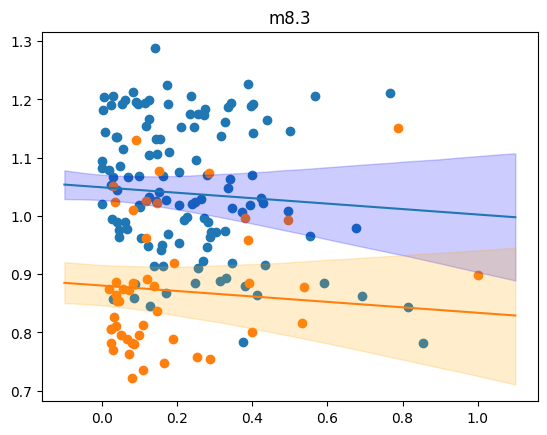

In [149]:
plt.scatter(rugged_std[cid == 1], log_gdp_std[cid == 1])
plt.scatter(rugged_std[cid == 0], log_gdp_std[cid == 0])
plt.plot(rugged_seq, mu_notafrica_mu)
plt.plot(rugged_seq, mu_africa_mu)
plt.fill_between(rugged_seq, mu_notafrica_pi[:, 0], mu_notafrica_pi[:, 1], color='b', alpha=0.2)
plt.fill_between(rugged_seq, mu_africa_pi[:, 0], mu_africa_pi[:, 1], color='orange', alpha=0.2)
plt.title('m8.3')
;

### 8.1.3 Adding an interaction **does work**

In [135]:
# Code 8.13

with pm.Model() as model:
    a = pm.Normal('a', 1, 0.1, shape=2)
    b = pm.Normal('b', 0, 0.3, shape=2)
    sigma = pm.Exponential('sigma', 1)
    mu = a[cid] + b[cid] * (rugged_std - 0.215)
    gdp_result = pm.Normal('gdp_result', mu, sigma, observed=log_gdp_std)
    post83, vars_ = quap(model)
    trace83 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


In [136]:
# Code 8.14

az.summary(trace83, kind='stats', round_to=2)

,mean,sd,hdi_3%,hdi_97%
a[0],0.89,0.02,0.86,0.92
a[1],1.05,0.01,1.03,1.07
b[0],0.13,0.08,-0.00,0.28
b[1],-0.14,0.05,-0.25,-0.04
sigma,0.11,0.01,0.10,0.12


In [140]:
# Code 8.15

az.compare({
    'm83': trace83,
    'm82': trace82,
    'm81': trace81,
}, ic='waic', scale='deviance')

/Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m83,0,-259.571690,4.802872,0.000000,0.882866,14.632274,0.000000,True,deviance
m82,1,-252.410782,4.067921,7.160908,0.117134,14.829148,6.487261,True,deviance
m81,2,-188.908832,2.562266,70.662858,0.000000,12.941568,14.897783,False,deviance


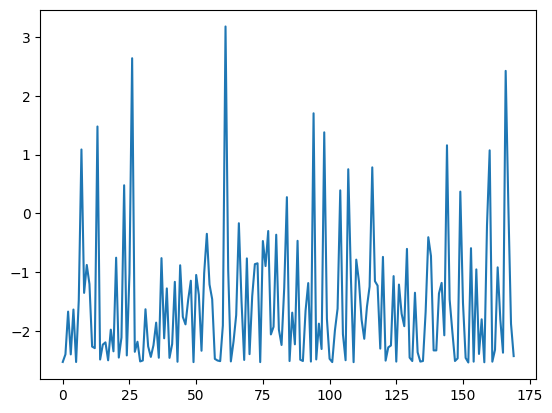

In [148]:
# Code 8.16

m83_loo = az.loo(trace83, pointwise=True, scale='deviance')
plt.plot(m83_loo.loo_i);

### 8.1.4 Plotting the interaction

In [165]:
rugged_seq = np.linspace(-0.1, 1.1, 30)

link = post83.rvs(size=10_000)

mu_notafrica = link[:, 1:2] + np.dot(link[:, 3:4], np.atleast_2d(rugged_seq))
mu_africa = link[:, 0:1] + np.dot(link[:, 2:3], np.atleast_2d(rugged_seq))

# summarize to means and intervals
mu_notafrica_mu = mu_notafrica.mean(axis=0)
mu_notafrica_pi = np.array([np.quantile(mu_, [0.015, 0.985]) for mu_ in mu_notafrica.T])

mu_africa_mu = mu_africa.mean(axis=0)
mu_africa_pi = np.array([np.quantile(mu_, [0.015, 0.985]) for mu_ in mu_africa.T])

''

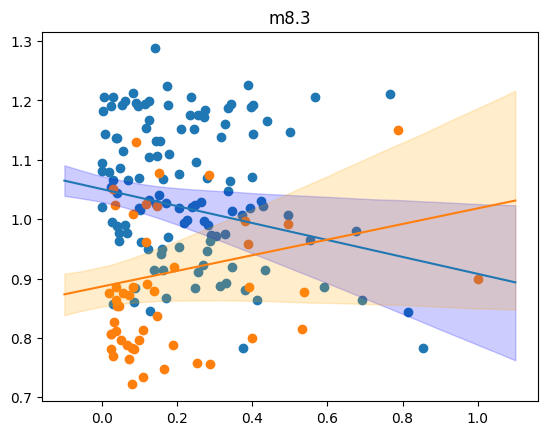

In [166]:
plt.scatter(rugged_std[cid == 1], log_gdp_std[cid == 1])
plt.scatter(rugged_std[cid == 0], log_gdp_std[cid == 0])
plt.plot(rugged_seq, mu_notafrica_mu)
plt.plot(rugged_seq, mu_africa_mu)
plt.fill_between(rugged_seq, mu_notafrica_pi[:, 0], mu_notafrica_pi[:, 1], color='b', alpha=0.2)
plt.fill_between(rugged_seq, mu_africa_pi[:, 0], mu_africa_pi[:, 1], color='orange', alpha=0.2)
plt.title('m8.3')
;

## 8.2 Symmetry of interactions

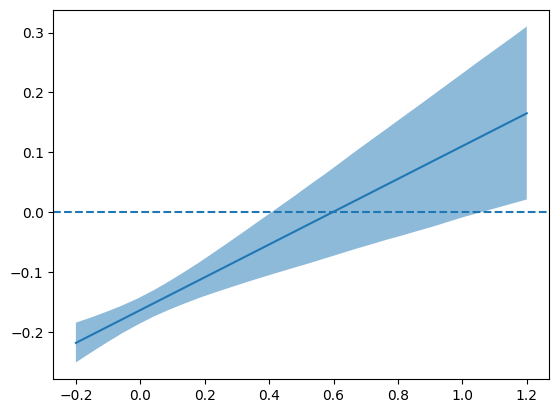

In [173]:
# Code 8.18

link = post83.rvs(size=10_000)

rugged_seq = np.linspace(-0.2, 1.2, 30)
mu_notafrica = link[:, 1:2] + np.dot(link[:, 3:4], np.atleast_2d(rugged_seq))
mu_africa = link[:, 0:1] + np.dot(link[:, 2:3], np.atleast_2d(rugged_seq))

delta = mu_africa_mu - mu_notafrica

# summarize to means and intervals
delta_mu = delta.mean(axis=0)
delta_pi = np.array([np.quantile(mu_, [0.015, 0.985]) for mu_ in delta.T])

plt.plot(rugged_seq, delta_mu)
plt.axhline(0, ls="--")
plt.fill_between(rugged_seq, delta_pi[:, 0], delta_pi[:, 1], alpha=0.5);

## 8.3 Continuous interactions

### 8.3.1 A winter flower

In [177]:
# Code 8.19
d = pd.read_csv(DATA_PATH.joinpath('tulips.csv'), sep=';')
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bed     27 non-null     object 
 1   water   27 non-null     int64  
 2   shade   27 non-null     int64  
 3   blooms  27 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 992.0+ bytes


Mathematical models:

$$
\begin{aligned}
B_i &\sim \text{Normal}(\mu_i,\sigma) \\
\mu_i &=  \alpha + \beta_W(W_i - \bar{W}) + \beta_S(S_i - \bar{S}) \\
\alpha &\sim \text{Normal}(0.5, 0.25) \\
\beta_W  &\sim \text{Normal}(0, 0.25) \\
\beta_S &\sim \text{Normal}(0, 0.25)
\end{aligned}
$$

### 8.3.2 The models

In [178]:
# Code 8.20
blooms_std = (d['blooms'] / d['blooms'].max()).values
water_cent = (d['water'] - d['water'].mean()).values
shade_cent = (d['shade'] - d['shade'].mean()).values

In [180]:
# Code 8.21
a = np.random.normal(0.5, 1, 1_000)
sum((a < 0) | (a > 1)) / len(a)

0.597

In [181]:
# Code 8.22
a = np.random.normal(0.5, 0.25, 1_000)
sum((a < 0) | (a > 1)) / len(a)

0.041

In [182]:
# Code 8.23

with pm.Model() as model:
    a = pm.Normal('a', 0.5, 0.25)
    bw = pm.Normal('bw', 0, 0.25)
    bs = pm.Normal('bs', 0, 0.25)
    sigma = pm.Exponential('sigma', 1)
    mu = a + bw * water_cent + bs * shade_cent
    blooms_o = pm.Normal('blooms_o', mu, sigma, observed=blooms_std)
    post84, vars_ = quap(model)
    trace84 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bw, bs, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


Mathematical model:

$$
\begin{aligned}
B_i &\sim \text{Normal}(\mu_i,\sigma) \\
\mu_i &=  \alpha + \beta_WW_i + \beta_SS_i + \beta_{WS}W_iS_i \\
\end{aligned}
$$

In [183]:
# Code 8.24

with pm.Model() as model:
    a = pm.Normal('a', 0.5, 0.25)
    bw = pm.Normal('bw', 0, 0.25)
    bs = pm.Normal('bs', 0, 0.25)
    bws = pm.Normal('bws', 0, 0.25)
    sigma = pm.Exponential('sigma', 1)
    mu = a + bw * water_cent + bs * shade_cent + bws * water_cent * shade_cent
    blooms_o = pm.Normal('blooms_o', mu, sigma, observed=blooms_std)
    post85, vars_ = quap(model)
    trace85 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bw, bs, bws, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


In [198]:
az.summary(trace85, kind='stats', round_to=2)

,mean,sd,hdi_3%,hdi_97%
a,0.36,0.03,0.31,0.41
bw,0.21,0.03,0.14,0.27
bs,-0.11,0.03,-0.18,-0.05
bws,-0.14,0.04,-0.22,-0.07
sigma,0.14,0.02,0.10,0.18


### 8.3.3 Plotting posterior predictions

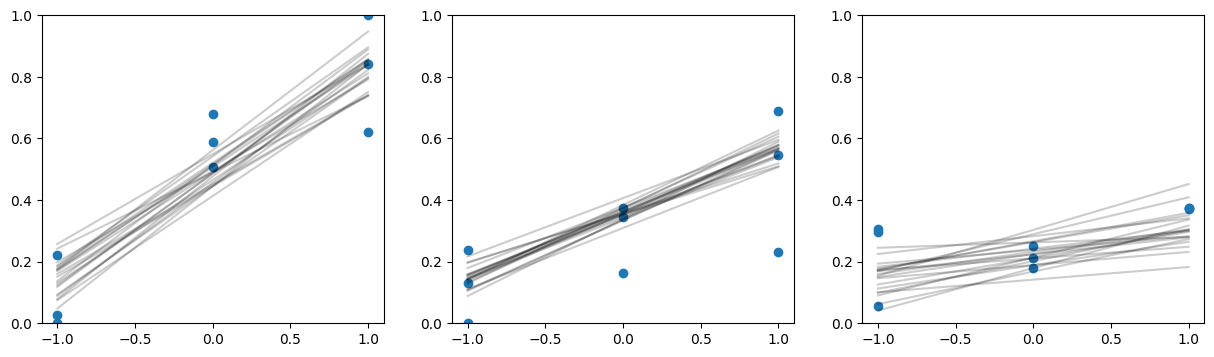

In [223]:
link = post85.rvs(20)
plt.figure(figsize=(15,4))

water = np.array([-1, 1]).reshape(1, -1)
for i, shade in enumerate(range(-1, 2)):
    plt.subplot(1, 3, i+1)
    idx = shade_cent == shade
    plt.scatter(water_cent[idx], blooms_std[idx])
    plt.ylim(0, 1)
    mus = (
        link[:, 0:1] 
        + link[:, 1:2]*water 
        + link[:, 2:3]*shade 
        + link[:, 3:4]*water*shade
    )
    for mu in mus:
        plt.plot(water[0], mu, color='k', alpha=0.2)
    

### 8.3.4 Plotting prior predictions

In [224]:
with model:
    trace86_prior = pm.sample_prior_predictive()

## Summary

> **Interactions**: Allows association between predictor and outcome to depend upon the value of another predictor.

These interactions might not be seen in a DAG, but they exist and are important to make accurate predictions.

> **triptych** plots: Help in visualizing the effect of an interaction.